# TODOs for today

Write the dynamics for the case of non infinite dynamics

And the write the markovian version

In [1]:
import numpy as np
import qutip as qt
import jax
import jax.numpy as jnp
from jax import jit
import matplotlib.pyplot as plt
from qbism import sic_povm

In [10]:
sigma_vector = jnp.array([qt.sigmax(), qt.sigmay(), qt.sigmaz()])

In [11]:
@jit
def vec(A):
    return A.flatten()


@jit
def generate_map(G):
    g_of_t = G
    return jnp.array(
        [
            [jnp.conjugate(g_of_t) * g_of_t, 0, 0, 0],
            [0, g_of_t, 0, 0],
            [0, 0, jnp.conjugate(g_of_t), 0],
            [1 - jnp.conjugate(g_of_t) * g_of_t, 0, 0, 1],
        ]
    )


@jit
def G(t, lamda, gamma_0):
    delta = jnp.sqrt((1 - 2 * gamma_0 / lamda) + 1j * 0)
    return jnp.exp(-lamda * t / 2) * (
        jnp.cosh(lamda * t / 2 * delta)
        + 1 / delta * jnp.sinh(lamda * t / 2 * delta)
    )


@jit
def name_of_fun_rho_comps(
    initial_state,
    sigma_vector,
    times_array,
    lamda,
    gamma_0,
):
    evolved_rho = jax.vmap(
        lambda t: generate_map(G(t, lamda, gamma_0)) @ vec(initial_state)
    )(times_array)

    evolved_bloch_comps = jax.vmap(
        lambda rho: jnp.einsum("kj, ijk", rho.reshape(2, 2), sigma_vector)
    )(evolved_rho)

    return evolved_bloch_comps

In [12]:
sic_array = jnp.array(sic_povm(2))

In [19]:
N = 1000
initial_rho_array = jnp.array([qt.rand_dm_ginibre(2) for _ in range(N)])

In [20]:
lamda = 0.8
gamma_0 = 0.8 * lamda / 2  # weak coupling
# gamma_0 = 20 * lamda / 2  # strong coupling


times = np.linspace(0, 20, 5000)

initial_rho0 = jnp.array(qt.rand_dm(2, seed=8).full())

sic_array = jnp.array(sic_povm(2))


# jax.jit(name_of_fun)(initial_rho0, sic_array, times, lamda, gamma_0)

evolved_bloch_comps = jax.vmap(
    lambda rho_i: (name_of_fun_rho_comps)(
        rho_i, sigma_vector, times, lamda, gamma_0
    )
)(initial_rho_array)

In [21]:
evolved_bloch_comps.shape

(1000, 5000, 3)

/opt/homebrew/Caskroom/mambaforge/base/envs/data-sci/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


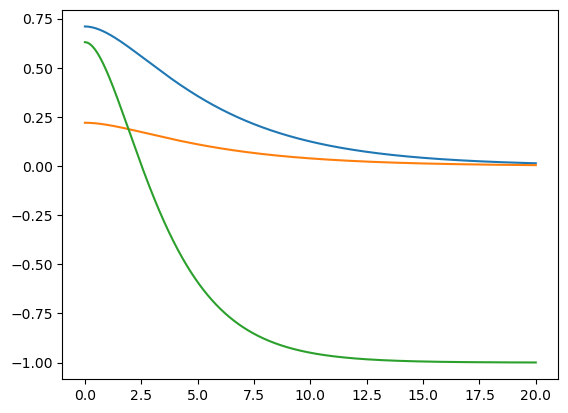

In [22]:
plt.plot(times, evolved_bloch_comps[45])

In [23]:
import joblib

data_to_save = {
    "lambda": lamda,
    "gamma_0": gamma_0,
    "times": np.array(times),
    "Initial_rhos": np.array(initial_rho_array),
    "povm_arr": np.array(sic_array),
    "prob arr": np.array(evolved_bloch_comps),
}

joblib.dump(data_to_save, "weak_coupling_dataset_bloch.job", compress=0)

['weak_coupling_dataset_bloch.job']